<a href="https://colab.research.google.com/github/Kimp25/Clasificador-de-gastos/blob/main/Expenses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from collections import Counter

In [14]:
# Cargar y preparar los datos
def cargar_datos(ruta_archivo):
    # Leer archivo sin especificar nombres de columna
    df = pd.read_csv(ruta_archivo, header=None, encoding='latin-1', on_bad_lines='skip')

    # Verificación de estructura
    if df.shape[1] < 2:
        raise ValueError("El archivo debe tener al menos dos columnas: una para las categorías y otra para el texto.")

    # Asignar nombres a las columnas
    df.columns = ['Category', 'Text'] + list(range(2, df.shape[1]))

    # Factorizar categorías
    df['category_id'] = df['Category'].factorize()[0]
    return df

In [15]:

# Cargar y preprocesar los datos
ruta_archivo = '/content/Expense22.csv'
df = cargar_datos(ruta_archivo)

# Convertir texto a características TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['Text']).toarray()
labels = df['category_id']

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Category'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [16]:

# Entrenar el modelo
clf = LogisticRegression().fit(X_train_tfidf, y_train)

In [18]:
# Probar predicción
results = clf.predict(count_vect.transform(["internet"]))
print("Predicción:", results)

Predicción: ['Entretenimiento']


In [20]:
# Evaluar modelos
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


<ipython-input-21-9ba1a627c720>:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)


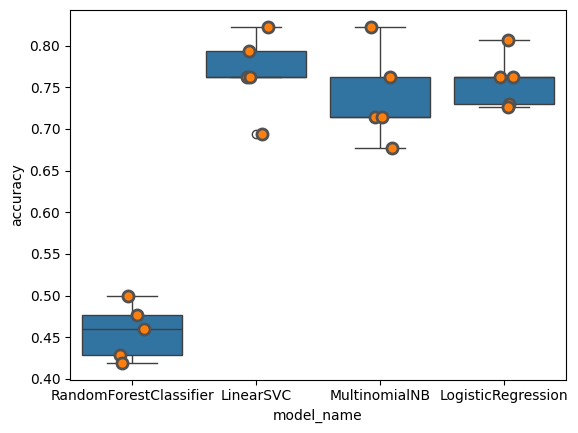

Precisión promedio por modelo: model_name
LinearSVC                 0.766718
LogisticRegression        0.757245
MultinomialNB             0.738095
RandomForestClassifier    0.456887
Name: accuracy, dtype: float64


In [21]:
# Gráficos de precisión de los modelos
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
print("Precisión promedio por modelo:", cv_df.groupby('model_name').accuracy.mean())

In [10]:
# Matriz de confusión
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

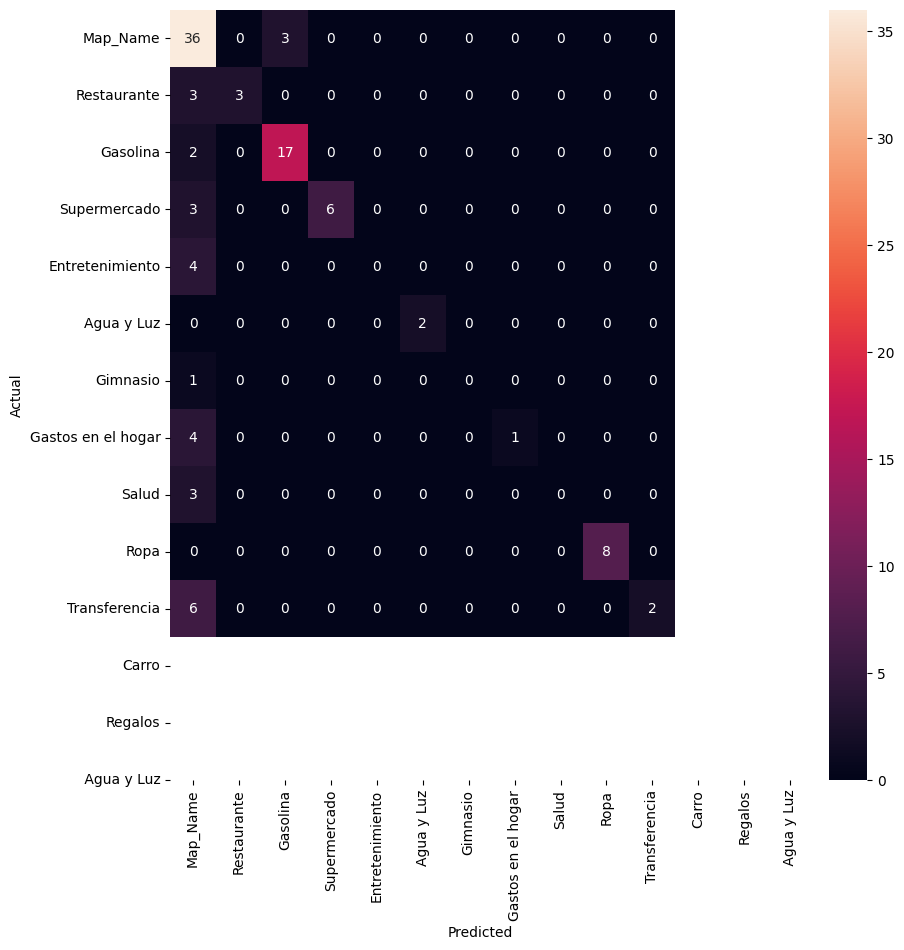

In [11]:
# Mostrar la matriz de confusión
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['Category'].unique(), yticklabels=df['Category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


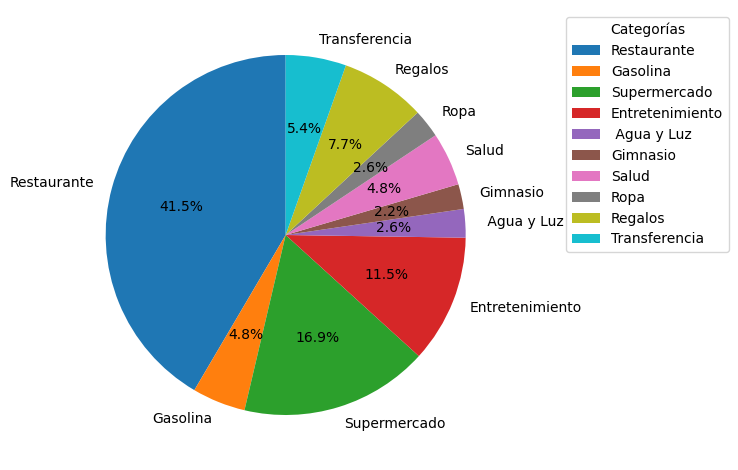

In [12]:

# Cargar datos para predicción
test_data = cargar_datos(ruta_archivo)

# Realizar predicciones sin depender de "Total_Expense"
test_data["predicted"] = clf.predict(count_vect.transform(test_data['Text']))
conteo_categorias = Counter(test_data["predicted"])

# Crear gráfico circular basado en el conteo de categorías predichas
plt.pie(conteo_categorias.values(),
        labels=conteo_categorias.keys(),
        autopct='%1.1f%%',
        startangle=90)

# Leyenda
plt.legend(conteo_categorias.keys(), title="Categorías", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()


In [ ]:
import pickle
from google.colab import files
# Guarda el modelo
with open('modelo_gastos.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Guarda el CountVectorizer
with open('count_vect.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

# Guarda el TfidfTransformer
with open('tfidf_transformer.pkl', 'wb') as f:
    pickle.dump(tfidf_transformer, f)

# Descargar los archivos en Cola
files.download('modelo_gastos.pkl')
files.download('count_vect.pkl')
files.download('tfidf_transformer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>